# HOGP 教程:
作者：ZhenjieLu, Wei W Xing  <br />
日期：2023-12-1    <br />
修改：2023-12-7、2024-2-5    <br />

大多数高斯过程（GP）工作侧重于学习单个输出函数，但许多应用，如物理模拟和基因表达预测，需要对具有许多输出的函数进行估计。HOGP相对于普通的GP，其实现更加的复杂，在输入和潜在特征上使用具有Kronecker乘积结构，使其能对数百万个输出进行精确推理，更容易拓展到高维空间。

## 背景知识：<br />
### 1.Kronecker积的定义<br />
一般而言，给定任意矩阵$ \mathbf{X} \in \mathbf{R}^{m \times n} $和$\mathbf{Y} \in \mathbf{R}^{p \times q}$，则矩阵$\mathbf{X}$ 和矩阵 $\mathbf{Y}$ 的Kronecker积为<br />
$$(\mathbf{X} \otimes \mathbf{Y})_{(i \cdot p) + k, (j \cdot q) + l} = X_{i, j} \cdot {Y}_{k, l}$$
或者
$$\mathbf{X} \otimes \mathbf{Y} = \begin{bmatrix} X_{1, 1} \cdot \mathbf{Y} & X_{1, 2} \cdot \mathbf{Y} & \cdots & X_{1, n} \cdot \mathbf{Y} \\ X_{2, 1} \cdot \mathbf{Y} & X_{2, 2} \cdot \mathbf{Y} & \cdots & X_{2, n} \cdot \mathbf{Y} \\ \vdots & \vdots & \ddots & \vdots \\ X_{m, 1} \cdot \mathbf{Y} & X_{m, 2} \cdot \mathbf{Y} & \cdots & X_{m, n} \cdot \mathbf{Y} \end{bmatrix}$$
具体知识可参考维基百科：https://en.wikipedia.org/wiki/Kronecker_product

### 2.Tucker运算<br />
张量分解（tensor decomposition）是一种将一个高阶张量表示为多个低秩张量乘积的方法。Tucker分解是其中一种常用的张量分解方法，它将一个张量分解为一个核张量（core tensor）与一组因子矩阵（factor matrices）。Tucker运算指的是使用Tucker分解来进行张量的乘法和重构。

### 3.模式张量矩阵乘积<br/>
给定一个张量$M∈R^{r_1×··×r_Q×p}$，$U∈R^{s×t}$,当$r_k = t$时，可以在张量$M$的第$k$个模式上与矩阵$U$进行乘法运算，得到一个新的张量$N∈R^{r_1×··×r_{k-1}×s×r_{k+1}×··×r_Q×p}$。

### 4.特征分解
特征分解（Eigendecomposition），又称谱分解（Spectral decomposition）是将矩阵分解为由其特征值和特征向量表示的矩阵之积的方法。
若$A$是一个$N$ x $N$的方阵,且有$N$个线性独立的特征向量$q_i$(i=1,...,N),这样,$A$可以被分解为$$A = QΛQ^{-1}$$
其中$Q$是$N$×$N$方阵，且其第$i$列为$A$的特征向量$q_i$。$Λ$ 是对角矩阵，其对角线上的元素为对应的特征值，也即 $Λ_{ii}$=$\lambda_i$。

通过特征分解的方法可以求反(逆)矩阵
若矩阵$A$可被特征分解并特征值中不含零，则矩阵$A$为非奇异矩阵，且其逆矩阵可以由下式给出：
$$A^{-1} = QΛ^{-1}Q^{-1} $$
因为$Λ$为对角矩阵，其逆矩阵容易计算出：
$\left[\Lambda^{-1}\right]_{ii}=\frac{1}{\lambda_i}$

具体知识可以参考维基百科：https://zh.wikipedia.org/wiki/%E7%89%B9%E5%BE%81%E5%88%86%E8%A7%A3<br />



In [1]:
import torch


class eigen_pairs:
    def __init__(self, matrix) -> None:
        eigen_value, eigen_vector = torch.linalg.eigh(matrix, UPLO='U')
        self.value = eigen_value
        self.vector = eigen_vector

## 1. 开始
HOGP可以处理多维数据，在这篇教程中，为了介绍HOGP，我们假设一个简单的例子，即在给定输入$\mathbf{x}$的情况下预测图像的像素值(两个像素越接近，它们的相关性就越强)，即二维输出$y \in \mathbf{R}^{d_1 \times d_2}$。相对应的
$\mathbf{x} \in \mathbf{R}^D$，输入的$\mathbf{x}$是一个D维的向量。<br />
那么让我们开始吧～ 由于这篇应用是基于Torch开发的，所以我们将从导入Torch库作为开端。

In [2]:
import torch.nn as nn

# from torch.autograd import Variable

torch.manual_seed(1)  #set seed for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
print(torch.__version__)
print(device)


2.2.1
cuda


## 2. 加载训练数据
我们为本教程准备了256组图像数据$x,y$，存放在data_sample中，其中128组用于训练$xtr,ytr$，128组用于测试$xte,yte$。在训练前，我们将数据组织成tensor，并对数据进行归一化处理，HOGP可以处理多维数据，因此我们还需要在定义HOGP时获取输出维度。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import core.GP_CommonCalculation as GP

x = np.load('D:\iceLab\data_sample\input.npy')
x = torch.tensor(x, dtype=torch.float64).to(device)
y = np.load('D:\iceLab\data_sample\output_fidelity_2.npy')
y = torch.tensor(y, dtype=torch.float64).to(device)

## Normalize data, currently using full dimensional standardization
normalizer = GP.DataNormalization(mode=1)
normalizer.fit(x, 'x')
normalizer.fit(y, 'y')
x = normalizer.normalize(x, 'x')
y = normalizer.normalize(y, 'y')

xtr = x[:128, :]
ytr = y[:128, :]
xte = x[128:, :]
yte = y[128:, :]

output_shape = ytr[0, ...].shape


## 2. 核函数以及模型参数（超参数）
HOGP使用到核函数，我们需要优化的函数是：均值函数以及核函数。我们需要给定这些函数的特定形式，之后再去优化他们的参数。在这篇教程中，我们设定均值函数为零（不需要优化均值函数）。而核函数部分，我们使用最常用的automatic relevance determinant（ARD）核函数：
$$k_{ard}(\mathbf{x}, \mathbf{x}') = a \cdot \exp(-\frac{1}{2} \sum_{d=1}^D{ (\frac{x_d-x'_d}{l_d}})^2 )$$
其中$a$是核函数的振幅，$l_d$是输入变量$x$的d维输入${x}_d$的长度系数（length scale）。$\mathbf{l}$ 控制着每个输入维度的贡献量，比如：$l_d$数值越大，则${x}_d$相比于其他维度在系统中的贡献越大；反之亦然。因此，这个函数被称为ARD，即可以自动控制相关性。 <br />
现在我们可以定义核函数了，其返回值为输入两组数据的一个核矩阵，但在这篇教程中，我们最终导入kernel文件中的ARD核函数。但两者是一个东西。

In [4]:
import core.kernel as kernel

EPS = 1e-9


class ARDKernel(nn.Module):
    """
    ARD (Automatic Relevance Determination) kernel module.

    Args:
        input_dim (int): The input dimension.
        initial_length_scale (float): The initial length scale value. Default is 1.0.
        initial_signal_variance (float): The initial signal variance value. Default is 1.0.
        eps (float): A small constant to prevent division by zero. Default is 1e-9.

    Attributes:
        length_scales (nn.Parameter): The length scales for each dimension.
        signal_variance (nn.Parameter): The signal variance.
        eps (float): A small constant to prevent division by zero.

    """

    def __init__(self, input_dim, initial_length_scale=1.0, initial_signal_variance=1.0, eps=EPS):
        super().__init__()
        self.length_scales = nn.Parameter(torch.ones(input_dim) * initial_length_scale)
        self.signal_variance = nn.Parameter(torch.tensor([initial_signal_variance]))
        self.eps = eps

    def forward(self, x1, x2):
        """
        Compute the covariance matrix using the ARD kernel.

        Args:
            x1 (torch.Tensor): The first input tensor.
            x2 (torch.Tensor): The second input tensor.

        Returns:
            torch.Tensor: The covariance matrix.

        """
        length_scales = torch.abs(self.length_scales) + self.eps

        scaled_x1 = x1 / length_scales
        scaled_x2 = x2 / length_scales
        sqdist = torch.cdist(scaled_x1, scaled_x2, p=2) ** 2
        return self.signal_variance.abs() * torch.exp(-0.5 * sqdist)

## 3. HOGP_simple类初始化
回到我们这个例子。一般来说，函数输出并不表示图像像素；HOGP没有明确的坐标来索引输出并反映它们的相关性。为了解决这个问题，HOGP将所有输出重新排列到多维空间（即张量空间）中，并引入潜在的坐标特征来索引输出并捕捉它们的相关性(self.grid),输入与潜在特征的映射用mapping_vector表示。最后，我们将输入和潜在特征相结合，为重新排列的输出建立GP回归模型。<br/>
具体来说，给定训练数据集D，其中$y$被组织为一个$Q$模的张量，即$y∈R^{d_1×··×d_Q}$,这里我们可以使用$Q+1$模张量$Z∈R^{d_1×··×d_Q ×N}$来表示N个训练输入的所有观测输出。这样训练数据可以表示为$(X,Z)$，将潜在特征向量堆叠成Q个矩阵，$V＝${$V^1,...,V^Q$}，其中$V_k（1≤k≤Q）$中的行是模$k$中坐标的特征向量。因此，每个$V_k$是一个$d_k×r_k$矩阵，其中$r_k$是模式$k$中特征向量的维数。<br/>
我们首先从高斯先验中采样一个权重张量$W∈R^{r_1×··×r_Q×p}$，$p(W) = N(vec(W)|0,I)$， 我们从$p(Z|X,V) = N(vec(Z)|vec(F),τ^{-1}I)$中采样$Z$,$τ$是逆方差，我们有$$F = W ×_1 V^1 ... ×_Q V^Q ×_{Q+1} X$$
由塔克张量性质可得$$vec(F) = (V^1⊗...⊗V^Q⊗X)vec(W)$$
得到多元线性回归模型的联合概率是$$p(Z,W|X,V,τ) = N(vec(W)|0,I)*N(vec(Z)|vec(F),τ^{-1}I)$$
$Z$的边际概率由下式给出$$p(Z|X,V,τ)= N(vec(Z)|0, Σ+ τ^{-1}I)$$
$$Σ = V^1(V^1)^T ⊗ ... ⊗V^Q(V^Q)^T ⊗ XX^T$$
HOGP结合了原始输入$X$和潜在坐标特征$V$，通过多线性Tucker算子生成所有输出。以$V^1$为例，用映射的特征向量$φ（v^1_j）$来替换$V^1$中的每一行$v^1_j$。用$φ(V^1)$表示映射的特征矩阵。用核矩阵$K^1$代替$φ(V^1)φ(V^1)^T$，其中每个元素$[K^1]_{i,j} = k_1(v^1_i ,v^1_j )$是一个执行隐式特征映射和内积的核函数,我们得到：
$$p(Z|X, V, τ ) = N (vec(Z)|0, K^1 ⊗ ... ⊗ K^Q ⊗ K + τ^{-1}I)$$
其中{$K^1,...,K^Q$}是输入X的潜在坐标特征{$V^1,...,V^Q$}的核矩阵，$K$是输入$X$的核矩阵，以我们的例子为例，我们的HOGP就需要有2+1个核函数<br />
下面给出HOGP_simple_demo的初始化实现

In [5]:
class HOGP_simple_demo(nn.Module):
    def __init__(self, kernel, noise_variance, output_shape, learnable_grid=False, learnable_map=False):
        super().__init__()
        self.noise_variance = nn.Parameter(torch.tensor([noise_variance]))
        self.kernel_list = []
        self.K = []
        self.K_eigen = []
        self.kernel_list = nn.ModuleList()
        for _ in range(len(output_shape) + 1):
            new_kernel = kernel
            self.kernel_list.append(new_kernel)
        ##Potential coordinate features
        self.grid = nn.ParameterList()
        for _value in output_shape:
            self.grid.append(nn.Parameter(torch.tensor(range(_value)).reshape(-1, 1).float()))
        if learnable_grid is False:
            for i in range(len(self.grid)):
                self.grid[i].requires_grad = False
        ##Latent feature mapping
        self.mapping_vector = nn.ParameterList()
        for _value in output_shape:
            self.mapping_vector.append(nn.Parameter(torch.eye(_value)))
        if learnable_map is False:
            for i in range(len(self.mapping_vector)):
                self.mapping_vector[i].requires_grad = False

## 4.对数似然函数（log likelihood）
HOGP是GP和潜在GP模型的混合——每个输出$y_c$与观察到的输入向量$x$和$Q$个潜在坐标特征向量{$v^1_{c_1},...,v^K_{c_K}$}相关联。因此，给定观测数据集$D$=（$X，Z$），推理需要估计$Q$模式张量空间中的所有潜在特征，$V$={$V^1,...,V^Q$}，以及潜在特征和原始输入的核参数，以及逆方差$τ$。<br />
类似于普通的GP，HOGP的对数似然函数为：
$$L = log (p(Z|X, V, τ )) = -\frac{1}{2} log |S| -\frac{1}{2} vec(Z)^TS^{−1}vec(Z) + const$$

其中$S = K^1⊗...⊗K^Q⊗K+τ^{−1}I$,符号 ⊗ 表示Kronecker积
为了更好的计算对数似然函数，首先用其特征分解(求特征值与特征向量)来表示$S$中的每个核矩阵$K$，即$K = Udiag(λ)U^T$,经过分解后$$S = U_1diag(λ_1)U_1^T ⊗...⊗ U_Qdiag(λ_Q)U^T_Q⊗Udiag(λ)U^T + τ^{-1}I$$
利用Kronecker乘积性质，我们可以得出：$$S = PΛP^T + τ^{−1}I$$
其中$P = U_1 ⊗...⊗ U_Q ⊗ U$ , $Λ = diag(λ_1 ⊗...⊗ λ_Q ⊗ λ)$
由于$U$和每个$U_k（1≤k≤Q）$都是特征向量并且是正交的，所以它们的Kronecker乘积也是正交的.<br />
进一步可以得到:
$$S = P(Λ + τ^{-1}I)P^T, S^{-1} = P(Λ + τ^{-1}I)^{−1}P^T$$
因此：
$log |S| = log |P(Λ + τ^{-1}I)P^T| = log |P^TP(Λ+τ^{-1}I)| = log |Λ+τ^{-1}|$<br />
对于对数似然函数的第二块：
$$vec(Z)^TS^{−1}vec(Z) = b^Tb$$
$$b = S^{-\frac{1}{2}}vec(Z) = P(Λ + τ^{−1})^{-\frac{1}{2}}P^T · vec(Z)$$
由于$P$是Kronecker乘积，我们可以递归地应用Tucker算子的性质来计算$b$<br />
$$T_1 = Z ×_1 U^T_1 ... ×_Q U^T_Q ×_{Q+1}U^T$$
$$T_2 = T_1 \bigodot A^{•-\frac{1}{2}}$$
$$T_3 = T_2 ×_1 U_1...×_QU_Q×_{Q+1}U $$
$$b = vec(T_3)$$
$\bigodot$表示元素乘积，$(·)•^{-\frac{1}{2}}$是对元素取二分之一的幂，$A^{•-\frac{1}{2}}$对应$(Λ + τ^-1I)^{-\frac{1}{2}}$的对角线<br />
接下来，我们把计算对数似然的过程编写出来


In [6]:
import math
import tensorly
from tensorly import tucker_to_tensor

tensorly.set_backend('pytorch')


def log_likelihood_demo(self, x_train, y_train):
    if isinstance(y_train, list):
        y_train_var = y_train[1]
        y_train = y_train[0]
    else:
        y_train_var = None

    ## Ensure that the K list is empty when calculating each epoch
    self.K.clear()
    self.K_eigen.clear()
    if y_train_var is not None:
        self.K.append(self.kernel_list[0](x_train, x_train) + y_train_var)
    else:
        self.K.append(self.kernel_list[0](x_train, x_train))
    self.K_eigen.append(eigen_pairs(self.K[-1]))

    ## Using matrix feature decomposition to reduce overhead
    for i in range(0, len(self.kernel_list) - 1):
        _in = tensorly.tenalg.mode_dot(self.grid[i], self.mapping_vector[i], 0)
        self.K.append(self.kernel_list[i + 1](_in, _in))
        self.K_eigen.append(eigen_pairs(self.K[-1]))
    _init_value = torch.tensor([1.0], device=list(self.parameters())[0].device).reshape(*[1 for i in self.K])
    lambda_list = [eigen.value.reshape(-1, 1) for eigen in self.K_eigen]
    A = tucker_to_tensor((_init_value, lambda_list))
    A = A + self.noise_variance.pow(-1) * tensorly.ones(A.shape, device=list(self.parameters())[0].device)

    T_1 = tensorly.tenalg.multi_mode_dot(y_train, [eigen.vector.T for eigen in self.K_eigen])
    T_2 = T_1 * A.pow(-1 / 2)
    T_3 = tensorly.tenalg.multi_mode_dot(T_2, [eigen.vector for eigen in self.K_eigen])
    b = tensorly.tensor_to_vec(T_3)
    g = tensorly.tenalg.multi_mode_dot(T_1 * A.pow(-1), [eigen.vector for eigen in self.K_eigen])

    ## Store the A and g for later use
    self.A = A
    self.g = g
    nd = torch.prod(torch.tensor([value for value in self.A.shape]))
    ## Calculate the log likelihood
    loss = -1 / 2 * nd * torch.log(torch.tensor(2 * math.pi, device=list(self.parameters())[0].device))
    loss += -1 / 2 * torch.log(self.A).sum()
    loss += -1 / 2 * b.t() @ b

    loss = -loss / nd
    return loss

## 5. 预测（Predict）
给定一个新的输入$x^*$,通过条件高斯分布计算d个输出的预测分布，张量化为$y^*$，即：
$$p(Y^*|x^*, D) = N (vec(Y^*)|μ^*, Σ^*) $$
预测的均值为：<br />
$$μ^* = (K^1 ⊗ ...⊗ K^Q ⊗ k_*)g $$
其中：$g = S^{−1}vec(Z)$，$g$的值在计算对数似然的时候已经计算并保存<br/>
预测的方差为：
$$Σ^* = (K^1 ⊗ ... ⊗ K^Q)k(x^*, x^*) − (K^1 ⊗ ...⊗ K^Q ⊗ k_*)S^{−1}(K^1 ⊗ ... ⊗ K^Q ⊗ k^T_*)$$
$$k_* = [k(x^*, x_1),..., k(x^*, x_N )]$$
有关均值的计算，我们可以使用Tucker运算进行有效计算，另外对于$Σ^*$的计算，可以使用上面提到的核矩阵特征分解的方法进行计算。但是，当$d$很大时，计算$d×d$预测协方差矩阵$∑*$是不实际的因此这里我们选择计算每个单独输出的方差。可以得出：
$$Σ^* = (K^1 ⊗...⊗ K^Q)k(x^*, x^*) − LL^T$$
其中$L = (U_1 ⊗...⊗ U_Q ⊗ k_*K^{−1}U)(Λ(Λ + τ^{−1}I)-\frac{1}{2})$<br />
所有预测的方差为：
$$diag(Σ^*) = k(x^*, x^*)diag(K_1 ⊗...⊗ K^Q) − diag(LL^T) = k(x^*, x^*)diag(K^1 ⊗ ...⊗ K^Q) − L^{•2} ·1$$
最后我们使用张量代数计算预测的方差：
$$diag(Σ^*) = vec(M)$$
$$M = k(x^*, x^*)·(diag(K^1)◦...◦diag(K^Q))+S^{•2}×_1U^{•2}_1...×_QU^{•2}_Q ×_{Q+1}(k_* K^{−1} U)^{•2}$$
其中$◦$为Kruskal算子<br />
预测过程的代码如下：


In [7]:
def forward_demo(self, x_train, x_test):
    K_star = self.kernel_list[0](x_test, x_train)
    K_predict = [K_star] + self.K[1:]

    predict_u = tensorly.tenalg.multi_mode_dot(self.g, K_predict)
    n_dim = len(self.K_eigen) - 1
    _init_value = torch.tensor([1.0]).reshape(*[1 for i in range(n_dim)]).to(x_train.device)
    #Reduce memory, therefore take diagonal elements
    diag_K_dims = tucker_to_tensor((_init_value, [K.diag().reshape(-1, 1) for K in self.K[1:]]))
    diag_K_dims = diag_K_dims.unsqueeze(0)
    diag_K_x = self.kernel_list[0](x_test, x_test).diag()
    for i in range(n_dim):
        diag_K_x = diag_K_x.unsqueeze(-1)
    diag_K = diag_K_x * diag_K_dims

    S = self.A * self.A.pow(-1 / 2)
    S_2 = S.pow(2)
    eigen_vectors_x = K_star @ self.K[0]
    eigen_vectors_dims = [self.K_eigen[i + 1].vector.pow(2) for i in range(n_dim)]

    eigen_vectors = [eigen_vectors_x] + eigen_vectors_dims
    S_product = tensorly.tenalg.multi_mode_dot(S_2, eigen_vectors)
    var_diag = diag_K + S_product

    return predict_u, var_diag

## 6.完整HOGP_simple定义
分别了解了HOGP各个模块以及参数后，下面我们给出完整的HOGP_simple定义，并进行实例化

In [27]:
class HOGP_simple(nn.Module):
    def __init__(self, kernel, noise_variance, output_shape, learnable_grid=False, learnable_map=False):
        super().__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.noise_variance = nn.Parameter(torch.tensor([noise_variance])).to(device)
        self.kernel_list = nn.ModuleList().to(device)
        self.K = []
        self.K_eigen = []
        for _ in range(len(output_shape) + 1):
            new_kernel = kernel
            self.kernel_list.append(new_kernel)
        self.grid = nn.ParameterList().to(device)
        for _value in output_shape:
            self.grid.append(nn.Parameter(torch.tensor(range(_value)).reshape(-1, 1).double()).to(device))
        if learnable_grid is False:
            for i in range(len(self.grid)):
                self.grid[i].requires_grad = False
        self.mapping_vector = nn.ParameterList().to(device)
        for _value in output_shape:
            self.mapping_vector.append(nn.Parameter(torch.eye(_value).double()).to(device))
        if learnable_map is False:
            for i in range(len(self.mapping_vector)):
                self.mapping_vector[i].requires_grad = False

    def forward(self, x_train, x_test):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        K_star = self.kernel_list[0](x_test, x_train)
        K_predict = [K_star] + self.K[1:]

        predict_u = tensorly.tenalg.multi_mode_dot(self.g, K_predict)
        n_dim = len(self.K_eigen) - 1
        _init_value = torch.tensor([1.0]).reshape(*[1 for i in range(n_dim)]).to(x_train.device)
        diag_K_dims = tucker_to_tensor((_init_value, [K.diag().reshape(-1, 1) for K in self.K[1:]]))
        diag_K_dims = diag_K_dims.unsqueeze(0)
        diag_K_x = self.kernel_list[0](x_test, x_test).diag()
        for i in range(n_dim):
            diag_K_x = diag_K_x.unsqueeze(-1)
        diag_K = diag_K_x * diag_K_dims

        S = self.A * self.A.pow(-1 / 2)
        S_2 = S.pow(2)
        eigen_vectors_x = K_star @ self.K[0]
        eigen_vectors_dims = [self.K_eigen[i + 1].vector.pow(2) for i in range(n_dim)]

        eigen_vectors = [eigen_vectors_x] + eigen_vectors_dims
        S_product = tensorly.tenalg.multi_mode_dot(S_2, eigen_vectors)
        var_diag = diag_K + S_product

        return predict_u, var_diag

    def log_likelihood(self, x_train, y_train):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        if isinstance(y_train, list):
            y_train_var = y_train[1]
            y_train = y_train[0]
        else:
            y_train_var = None

        self.K.clear()
        self.K_eigen.clear()
        if y_train_var is not None:
            self.K.append(self.kernel_list[0](x_train, x_train) + y_train_var)
        else:
            self.K.append(self.kernel_list[0](x_train, x_train))
        self.K_eigen.append(eigen_pairs(self.K[-1]))

        for i in range(0, len(self.kernel_list) - 1):
            _in = tensorly.tenalg.mode_dot(self.grid[i], self.mapping_vector[i], 0)
            self.K.append(self.kernel_list[i + 1](_in, _in))
            self.K_eigen.append(eigen_pairs(self.K[-1]))
        _init_value = torch.tensor([1.0], device=device).reshape(*[1 for i in self.K])
        lambda_list = [eigen.value.reshape(-1, 1) for eigen in self.K_eigen]
        A = tucker_to_tensor((_init_value, lambda_list))
        A = A + self.noise_variance.pow(-1) * tensorly.ones(A.shape, device=device)

        T_1 = tensorly.tenalg.multi_mode_dot(y_train, [eigen.vector.T for eigen in self.K_eigen])
        T_2 = T_1 * A.pow(-1 / 2)
        T_3 = tensorly.tenalg.multi_mode_dot(T_2, [eigen.vector for eigen in self.K_eigen])
        b = tensorly.tensor_to_vec(T_3)
        g = tensorly.tenalg.multi_mode_dot(T_1 * A.pow(-1), [eigen.vector for eigen in self.K_eigen])

        self.A = A
        self.g = g
        nd = torch.prod(torch.tensor([value for value in self.A.shape]))
        loss = -1 / 2 * nd * torch.log(torch.tensor(2 * math.pi, device=device))
        loss += -1 / 2 * torch.log(self.A).sum()
        loss += -1 / 2 * b.t() @ b

        loss = -loss / nd
        return loss


GPmodel = HOGP_simple(kernel=kernel.ARDKernel(1), noise_variance=1.0, output_shape=output_shape)

#### 7. 调用优化器并进行训练
当损失函数，也就是对数似然函数定义好之后，我们可以很简单地通过调用优化器来最小化损失函数值并进行训练~

In [28]:
optimizer = torch.optim.Adam(GPmodel.parameters(), lr=1e-2)
for i in range(100):
    optimizer.zero_grad()
    loss = GPmodel.log_likelihood(xtr, ytr)
    loss.backward()
    optimizer.step()
    print('iter', i, 'nll:{:.5f}'.format(loss.item()))

iter 0 nll:1.16068
iter 1 nll:1.15387
iter 2 nll:1.14725
iter 3 nll:1.14082
iter 4 nll:1.13458
iter 5 nll:1.12853
iter 6 nll:1.12267
iter 7 nll:1.11699
iter 8 nll:1.11150
iter 9 nll:1.10619
iter 10 nll:1.10105
iter 11 nll:1.09609
iter 12 nll:1.09130
iter 13 nll:1.08668
iter 14 nll:1.08222
iter 15 nll:1.07793
iter 16 nll:1.07378
iter 17 nll:1.06979
iter 18 nll:1.06595
iter 19 nll:1.06224
iter 20 nll:1.05868
iter 21 nll:1.05524
iter 22 nll:1.05194
iter 23 nll:1.04876
iter 24 nll:1.04570
iter 25 nll:1.04275
iter 26 nll:1.03991
iter 27 nll:1.03718
iter 28 nll:1.03455
iter 29 nll:1.03202
iter 30 nll:1.02958
iter 31 nll:1.02723
iter 32 nll:1.02496
iter 33 nll:1.02278
iter 34 nll:1.02068
iter 35 nll:1.01865
iter 36 nll:1.01669
iter 37 nll:1.01480
iter 38 nll:1.01298
iter 39 nll:1.01121
iter 40 nll:1.00951
iter 41 nll:1.00787
iter 42 nll:1.00628
iter 43 nll:1.00474
iter 44 nll:1.00325
iter 45 nll:1.00181
iter 46 nll:1.00041
iter 47 nll:0.99906
iter 48 nll:0.99775
iter 49 nll:0.99648
iter 50 nl

## 8. 预测与可视化
训练完HOGP后，我们使用测试数据$xte$进行预测，并将结果进行可视化，通过比较GroundTruth与预测值，以及他们的差值，我们可以看到HOGP的预测效果，这里只展示其中的一个预测结果，其余的可以自行尝试~

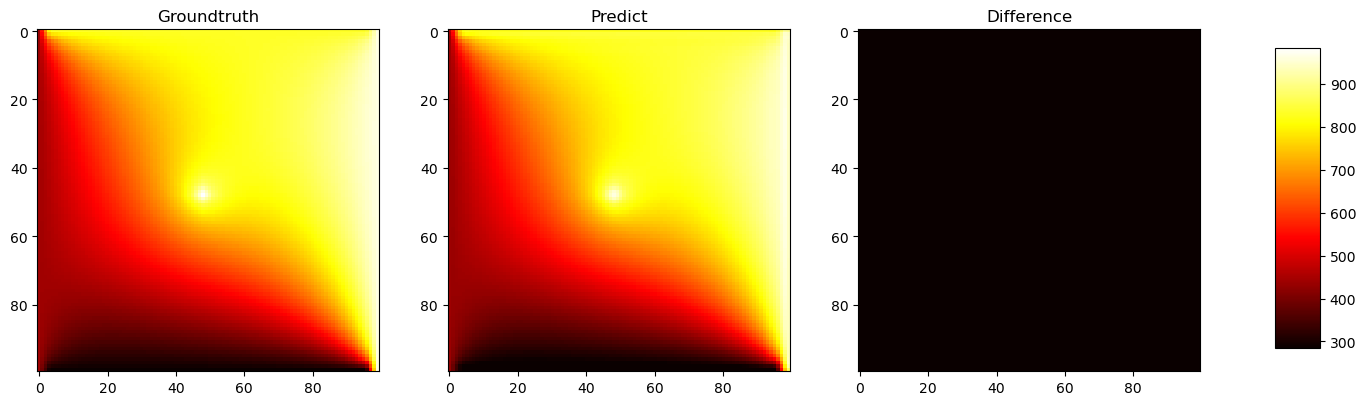

In [26]:
with torch.no_grad():
    ypred, ypred_var = GPmodel.forward(xtr, xte)
    ypred = normalizer.denormalize(ypred, 'y')

##plot_res_for_only_1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
yte = normalizer.denormalize(yte, 'y')
vmin = torch.min(yte[1])
vmax = torch.max(yte[1])

im = axs[0].imshow(yte[1].cpu(), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
axs[0].set_title('Groundtruth')

axs[1].imshow(ypred[1].cpu(), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
axs[1].set_title('Predict')

axs[2].imshow((yte[1].cpu() - ypred[1].cpu()).abs(), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
axs[2].set_title('Difference')

cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax)
plt.show()